# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import yaml
import csv
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from keras import Input, Model
from keras.activations import softmax
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.text import Tokenizer

# Data preparation

Loading the questions and answers set

In [ ]:
dir_path = os.path.join("/content/drive/My Drive/", "MLDAEEE_Hackathon_2021.10.15_17", "data")
files_list = os.listdir(dir_path)

Cleaning texts

In [ ]:
def clean_text(text_to_clean):
    res = text_to_clean.lower()
    res = re.sub(r"i'm", "i am", res)
    res = re.sub(r"he's", "he is", res)
    res = re.sub(r"she's", "she is", res)
    res = re.sub(r"it's", "it is", res)
    res = re.sub(r"that's", "that is", res)
    res = re.sub(r"what's", "what is", res)
    res = re.sub(r"where's", "where is", res)
    res = re.sub(r"how's", "how is", res)
    res = re.sub(r"\'ll", " will", res)
    res = re.sub(r"\'ve", " have", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"\'d", " would", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"won't", "will not", res)
    res = re.sub(r"can't", "cannot", res)
    res = re.sub(r"n't", " not", res)
    res = re.sub(r"n'", "ng", res)
    res = re.sub(r"'bout", "about", res)
    res = re.sub(r"'til", "until", res)
    res = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", res)
    # res = re.sub(r'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789', "", res)
    return res

Reading questions and answers and put them in list

In [ ]:
questions = []
answers_list = []
for filepath in files_list:
  stream = open(dir_path + "/" + filepath, 'rb')
  doc = yaml.safe_load(stream)
  conversations = doc['conversations']
  for conversation in conversations:
      questions.append(clean_text(str(conversation[0])))
      answers_list.append(clean_text(str(conversation[1])))

answers = []
for i in range(len(answers_list)):
  answers.append('<START> ' + answers_list[i] + ' <END>')

print(len(questions))
print(len(answers))

863
863


# Tokenizer
Tokenize the encoder input data, decoder input data and decoder output data

Generate tokens

In [ ]:
combined_sentences = questions + answers
target_regex = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789'
tokenizer = Tokenizer(filters = target_regex)
tokenizer.fit_on_texts(combined_sentences)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)
print(tokenizer.word_index)

2091
{'end': 1, 'start': 2, 'you': 3, 'i': 4, 'is': 5, 'a': 6, 'the': 7, 'what': 8, 'do': 9, 'of': 10, 'to': 11, 'not': 12, 'are': 13, 'and': 14, 'me': 15, 'am': 16, 'your': 17, 'it': 18, 'have': 19, 'in': 20, 'that': 21, 'get': 22, 'my': 23, 'tell': 24, 'can': 25, 'as': 26, 'how': 27, 'feel': 28, 'like': 29, 'for': 30, 'about': 31, 'or': 32, 'when': 33, 'with': 34, 'an': 35, 'be': 36, 'joke': 37, 'who': 38, 'computer': 39, 'on': 40, 'by': 41, 'should': 42, 'no': 43, 'cross': 44, 'good': 45, 'was': 46, 'but': 47, 'which': 48, 'more': 49, 'any': 50, 'think': 51, 'from': 52, 'eat': 53, 'he': 54, 'ever': 55, 'much': 56, 'so': 57, 'all': 58, 'why': 59, 'now': 60, 'favorite': 61, 'does': 62, 'one': 63, 'know': 64, 'makes': 65, 'if': 66, 'software': 67, 'yes': 68, 'will': 69, 'make': 70, 'mad': 71, 'very': 72, 'did': 73, 'sad': 74, 'money': 75, 'we': 76, 'stock': 77, 'robot': 78, 'at': 79, 'some': 80, 'angry': 81, 'this': 82, 'could': 83, 'would': 84, 'dream': 85, 'than': 86, 'hate': 87, 'em

Tokenizing the encoder input data

In [ ]:
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
encoder_input_data = pad_sequences(tokenized_questions, maxlen = maxlen_questions, padding = 'post')

print(maxlen_questions)
print(encoder_input_data.shape)
print(encoder_input_data)

22
(863, 22)
[[   9    3   64 ...    0    0    0]
 [   9    3   64 ...    0    0    0]
 [   9    3   64 ...    0    0    0]
 ...
 [   3  238  744 ...    0    0    0]
 [   3  238 1099 ...    0    0    0]
 [   3  187   15 ...    0    0    0]]


Tokenizing the decoder input data

In [ ]:
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
decoder_input_data = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding = 'post')

print(maxlen_answers)
print(decoder_input_data.shape)
print(decoder_input_data)

60
(863, 60)
[[   2 1100  118 ...    0    0    0]
 [   2  347    5 ...    0    0    0]
 [   2    4  394 ...    0    0    0]
 ...
 [   2   60   18 ...    0    0    0]
 [   2   23  514 ...    0    0    0]
 [   2  247   31 ...    0    0    0]]


Tokenizing the decoder output data 
(remove the < start > at the beginning)

In [ ]:
for i in range(len(tokenized_answers)):
  tokenized_answers[i] = tokenized_answers[i][1:]

padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding = 'post')
decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE)

print(maxlen_answers)
print(decoder_output_data)
print(decoder_output_data.shape)

60
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
(863, 6

# Training the model

Encoder

In [ ]:
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
_, state_h, state_c = LSTM(200, return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

Decoder

In [ ]:
dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(200, return_state = True, return_sequences = True)
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE, activation = softmax)
output = dec_dense(dec_outputs)

Model generate, compile

In [ ]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer = RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])

Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    418200      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    418200      input_2[0][0]                    
______________________________________________________________________________________________

Model fitting (actual training)

In [ ]:
model_history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,  batch_size = 50,  epochs = 300)

Epoch 1/300
18/18 [==============================] - 14s 59ms/step - loss: 1.2390 - accuracy: 0.1177
Epoch 2/300
18/18 [==============================] - 1s 60ms/step - loss: 1.0776 - accuracy: 0.1352
Epoch 3/300
18/18 [==============================] - 1s 60ms/step - loss: 1.0447 - accuracy: 0.1628
Epoch 4/300
18/18 [==============================] - 1s 58ms/step - loss: 1.0159 - accuracy: 0.1886
Epoch 5/300
18/18 [==============================] - 1s 60ms/step - loss: 0.9941 - accuracy: 0.1935
Epoch 6/300
18/18 [==============================] - 1s 58ms/step - loss: 0.9764 - accuracy: 0.1942
Epoch 7/300
18/18 [==============================] - 1s 59ms/step - loss: 0.9607 - accuracy: 0.1950
Epoch 8/300
18/18 [==============================] - 1s 55ms/step - loss: 0.9444 - accuracy: 0.1986
Epoch 9/300
18/18 [==============================] - 1s 58ms/step - loss: 0.9280 - accuracy: 0.2085
Epoch 10/300
18/18 [==============================] - 1s 57ms/step - loss: 0.9108 - accuracy: 0.221

# Plotting the training loss and accuracy

Storing history into csv

In [ ]:
print(model_history.history)

{'loss': [1.2390445470809937, 1.0775834321975708, 1.0446826219558716, 1.0158675909042358, 0.9940571784973145, 0.9764253497123718, 0.9606775641441345, 0.9444445967674255, 0.9279994368553162, 0.9107802510261536, 0.893062949180603, 0.8754766583442688, 0.8577798008918762, 0.840276837348938, 0.8232716917991638, 0.8060734272003174, 0.7897707223892212, 0.7742981910705566, 0.7597147226333618, 0.7440324425697327, 0.7305511236190796, 0.7158187031745911, 0.7026840448379517, 0.6892450451850891, 0.6757760047912598, 0.6626260876655579, 0.6489986181259155, 0.6366298198699951, 0.6239880323410034, 0.6111460328102112, 0.5986806750297546, 0.5867899656295776, 0.5741676092147827, 0.5618952512741089, 0.5501975417137146, 0.5380427837371826, 0.5261049270629883, 0.5151745080947876, 0.5034325122833252, 0.49255725741386414, 0.48079046607017517, 0.4700436294078827, 0.4587406814098358, 0.4484366774559021, 0.4384910464286804, 0.42652469873428345, 0.4175467789173126, 0.40729257464408875, 0.3971925377845764, 0.386154

In [ ]:
history_dict = {}
history_dict['epoch'] = [i+1 for i in range(300)]
history_dict['loss'] = model_history.history['loss']
history_dict['accuracy'] = model_history.history['accuracy']
print(history_dict)

csv_data = pd.DataFrame.from_dict(history_dict)
# print(csv_data)
csv_data.to_csv (r'/content/drive/My Drive/MLDAEEE_Hackathon_2021.10.15_17/model_history.csv', index = False, header=True)
print(csv_data)

{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

Plotting history

In [ ]:
long_dictionary = {'epoch': [], 'loss': [], 'accuracy': []}

with open('/content/drive/My Drive/MLDAEEE_Hackathon_2021.10.15_17/model_history.csv', 'r') as f_object:
        
    dictreader_object = csv.DictReader(f_object)
    # print(dictreader_object)

    ordered_dict_from_csv = list(dictreader_object)
    # print(ordered_dict_from_csv)

    for ordered_dict_each_row in ordered_dict_from_csv:
        for key, item in ordered_dict_each_row.items():
            # print(key, items)
            long_dictionary[key].append(item)

    #Close the file object
    f_object.close()

for i, epoch_str in enumerate(long_dictionary['epoch']):
    long_dictionary['epoch'][i] = int(epoch_str)
    
for i, loss_str in enumerate(long_dictionary['loss']):
    long_dictionary['loss'][i] = float(loss_str)

for i, accuracy_str in enumerate(long_dictionary['accuracy']):
    long_dictionary['accuracy'][i] = float(accuracy_str)

# print(json_dictionary)

Plotting training loss

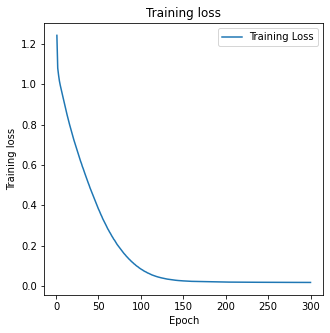

In [ ]:
impose_ylim = False
y_lim = [0,0.2]

loss = long_dictionary['loss']
epoch = long_dictionary['epoch']

plt.figure(figsize=(5, 5))
plt.plot(epoch, loss, label='Training Loss')

plt.ylabel('Training loss')
if impose_ylim:
    plt.ylim(y_lim)
plt.xlabel('Epoch')

plt.title('Training loss')
plt.legend(loc='upper right')
plt.show()

Plotting training accuracy

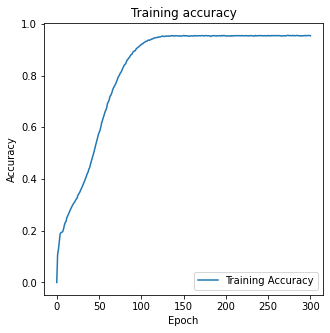

In [ ]:
impose_ylim = False
y_lim = [0.925,1]

acc = [0.] + long_dictionary['accuracy']
epoch = [0] + long_dictionary['epoch']

plt.figure(figsize=(5, 5))
plt.plot(epoch, acc, label='Training Accuracy')

plt.ylabel('Accuracy')
if impose_ylim:
    plt.ylim(y_lim)
plt.xlabel('Epoch')

plt.title('Training accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
print("Final accuray = {:.2f}%".format(long_dictionary['accuracy'][-1]*100))

Final accuray = 95.36%


# Model prediction

Define the encoding model

In [ ]:
enc_model = Model(inputs = enc_inputs, outputs = enc_states) # enc_inputs = Input(shape=(None,)) ; enc_states = [state_h, state_c] (shape=(200,))

enc_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 200)         418200    
_________________________________________________________________
lstm (LSTM)                  [(None, 200), (None, 200) 320800    
Total params: 739,000
Trainable params: 739,000
Non-trainable params: 0
_________________________________________________________________


Define the decoding model

In [ ]:
dec_state_input_h = Input(shape=(200,))
dec_state_input_c = Input(shape=(200,))

dec_states_inputs = [dec_state_input_h, dec_state_input_c]
dec_outputs, state_h, state_c = dec_lstm(dec_embedding, initial_state=dec_states_inputs)
dec_states = [state_h, state_c]
dec_outputs = dec_dense(dec_outputs)

dec_model = Model(inputs = [dec_inputs] + dec_states_inputs, # dec_inputs = Input(shape=(None,)) ; dec_states = [state_h, state_c] (shape=(200,))
                  outputs = [dec_outputs] + dec_states) # dec_outputs = dec_dense(dec_outputs) (1 X 1 X VOCAB_SIZE) ; dec_states = [state_h, state_c]

dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    418200      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
____________________________________________________________________________________________

String to tokens

In [ ]:
def str_to_tokens(sentence: str):
    words = clean_text(sentence).split()
    tokens_list = list() # empty list
    for current_word in words: # loop through the list of words
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return np.array(pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post'))
  
print(str_to_tokens("Hello world!"))

[[348 331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


Actual prediction

In [ ]:
def final_prediction(input_string):

  states_values = enc_model.predict(str_to_tokens(input_string))

  empty_target_seq = np.zeros((1,1))
  empty_target_seq[0,0] = tokenizer.word_index['start']

  stop_condition = False
  decoded_translation = ''

  while not stop_condition:
    dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
    sampled_word_index = np.argmax(dec_outputs[0,-1,:])
    sampled_word = None
    
    for word, index in tokenizer.word_index.items():
      if sampled_word_index == index:
        if word != 'end':
          decoded_translation += ' {}'.format(word)
        sampled_word = word
    
    # if hitting the end or hitting the max length of answers, then stop
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
      stop_condition = True
    
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = sampled_word_index
    states_values = [h,c]

  return decoded_translation[1:]

# User interface

In [ ]:
print("Hi hello, Welcome to this chatbot.\n" + 
"We are here to support your daily living and entertainments.\n" + "Please ask our chatbot of any questions you want,\n" + 
"ranging from greeting words, entertainments, \n" + "seeking for assistance, or mental health issues.\n" +
"We will try our best to answer your needs.\n\n" + "At any time you want to terminate the chatbot,\n" +  "please type the word 'end' to the question row.")
while True:
  input_string = input("\nEnter a question:   ")
  if input_string == "end" or input_string == "END" or input_string == "End":
    break
  output_string = final_prediction(input_string)
  print("Answer:             " + output_string)
print("\nThanks for using our chatbot, see you next time!")

Hi hello, Welcome to this chatbot.
We are here to support your daily living and entertainments.
Please ask our chatbot of any questions you want,
ranging from greeting words, entertainments, 
seeking for assistance, or mental health issues.
We will try our best to answer your needs.

At any time you want to terminate the chatbot,
please type the word 'end' to the question row.

Enter a question:   I feel boring
Answer:             but you got me

Enter a question:   I am ashamed
Answer:             why

Enter a question:   I feel I am incapable to love
Answer:             try not to be used to save your personality

Enter a question:   I feel my life is going to an end.
Answer:             i will accompany with you as always

Enter a question:   end

Thanks for using our chatbot, see you next time!
